# Language Translation with Word Level seq2seq DL Models
The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

We will use __Spanish-English__ sentence pairs data from http://www.manythings.org/anki/

Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

<img src="https://i.imgur.com/Uk1tCPo.png">

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:

+ The encoder
+ The decoder

Both these parts are essentially two different sequential models like RNNs\LSTMs which are combined together.

<img src="https://i.imgur.com/bT6PAtv.png">

## Download the Dataset

In [1]:
!wget http://www.manythings.org/anki/spa-eng.zip
!unzip spa-eng.zip
!ls -l

--2021-11-29 17:52:24--  http://www.manythings.org/anki/spa-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5326759 (5.1M) [application/zip]
Saving to: ‘spa-eng.zip’

spa-eng.zip         100%[===================>]   5.08M  7.18MB/s    in 0.7s    

2021-11-29 17:52:25 (7.18 MB/s) - ‘spa-eng.zip’ saved [5326759/5326759]

Archive:  spa-eng.zip
  inflating: _about.txt              
  inflating: spa.txt                 
total 25332
-rw-r--r-- 1 root root     1441 Nov 29 01:09 _about.txt
drwxr-xr-x 1 root root     4096 Nov 18 14:36 sample_data
-rw-r--r-- 1 root root  5326759 Nov 28 16:09 spa-eng.zip
-rw-r--r-- 1 root root 20602192 Nov 29 01:09 spa.txt


## Load the Dataset

In [2]:
import numpy as np

FILE_NAME = './spa.txt'
with open(FILE_NAME, mode='rt', encoding='utf-8') as infile:
  data = infile.read()
  sentences = data.strip().split('\n')
  sentences = [item.split('\t') for item in sentences]
  eng_spa = np.array(sentences)

eng_spa = eng_spa[:50000]
eng_spa

array([['Go.', 'Ve.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986655 (cueyayotl)'],
       ['Go.', 'Vete.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986656 (cueyayotl)'],
       ['Go.', 'Vaya.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #4986657 (cueyayotl)'],
       ...,
       ["That's not what you said.", 'No es lo que usted dijo.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2849776 (CK) & #8011524 (Seael)'],
       ["That's not what you said.", 'Eso no es lo que usted dijo.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2849776 (CK) & #8011525 (Seael)'],
       ["That's not what you said.", 'No es lo que ustedes dijeron.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2849776 (CK) & #8011526 (Seael)']],
      dtype='<U332')

In [3]:
spa = eng_spa[:,1]
eng = eng_spa[:,0]
eng, spa

(array(['Go.', 'Go.', 'Go.', ..., "That's not what you said.",
        "That's not what you said.", "That's not what you said."],
       dtype='<U332'),
 array(['Ve.', 'Vete.', 'Vaya.', ..., 'No es lo que usted dijo.',
        'Eso no es lo que usted dijo.', 'No es lo que ustedes dijeron.'],
       dtype='<U332'))

## Basic Preprocessing

In [4]:
import string

# Remove punctuation and lowercase
eng = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in eng])
spa = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in spa])
eng, spa

(array(['go', 'go', 'go', ..., 'thats not what you said',
        'thats not what you said', 'thats not what you said'], dtype='<U24'),
 array(['ve', 'vete', 'vaya', ..., 'no es lo que usted dijo',
        'eso no es lo que usted dijo', 'no es lo que ustedes dijeron'],
       dtype='<U66'))

## Analyze Sentences

### **Question 1**: Get maximum sentence length for both __English__ and __Spanish__ (2 points)


In [5]:
# Add your code here
eng_len = [len(s.split()) for s in eng]
spa_len = [len(s.split()) for s in spa]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff84672dc90>,
      dtype=object)

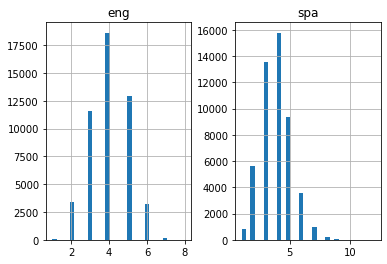

In [6]:
import pandas as pd
%matplotlib inline

length_df = pd.DataFrame({'eng':eng_len, 'spa':spa_len})
length_df.hist(bins=30)

## Transform Text to Sequence of Numbers

### **Question 2**: Use **``tensorflow.keras.tokenizer``** to tokenize and prepare a text to number mapping (2 points)


In [7]:
from tensorflow import keras

# Add your code here
eng_tokenizer = keras.preprocessing.text.Tokenizer()
eng_tokenizer.fit_on_texts(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max(eng_len)

In [8]:
print('Max eng text length:', eng_length)
print('English Vocabulary Size:', eng_vocab_size)

Max eng text length: 8
English Vocabulary Size: 6832


In [9]:
spa_tokenizer = keras.preprocessing.text.Tokenizer()
spa_tokenizer.fit_on_texts(spa)
spa_vocab_size = len(spa_tokenizer.word_index) + 1
spa_length = max(spa_len)

In [10]:
print('Max deu text length:', spa_length)
print('Spanish Vocabulary Size:', spa_vocab_size)

Max deu text length: 12
Spanish Vocabulary Size: 14042


## Prepare Train Test Splits

In [11]:
from sklearn.model_selection import train_test_split

train_spa, test_spa, train_eng, test_eng = train_test_split(spa, eng, test_size=0.2, random_state = 42)
train_spa.shape, test_spa.shape, train_eng.shape, test_eng.shape

((40000,), (10000,), (40000,), (10000,))

## Normalize Sequence Lengths
We normalize sentence lengths by defining the maximum length. Larger sentences/sequences get truncated while smaller ones are padded.

### **Question 3**: Normalize sentences by defining the max length. **Pad** shorter ones and truncate the longer ones. (2 points)

_Hint: use ``pad_sequences``_


In [12]:
# Add your code here
train_spa_enc = spa_tokenizer.texts_to_sequences(train_spa)
train_spa_enc = keras.preprocessing.sequence.pad_sequences(train_spa_enc, maxlen=spa_length, padding='post')

train_eng_enc = eng_tokenizer.texts_to_sequences(train_eng)
train_eng_enc = keras.preprocessing.sequence.pad_sequences(train_eng_enc, maxlen=eng_length, padding='post')

train_spa_enc.shape, train_eng_enc.shape

((40000, 12), (40000, 8))

In [13]:
# Add your code here
test_spa_enc = spa_tokenizer.texts_to_sequences(test_spa)
test_spa_enc = keras.preprocessing.sequence.pad_sequences(test_spa_enc, maxlen=spa_length, padding='post')

test_eng_enc = eng_tokenizer.texts_to_sequences(test_eng)
test_eng_enc = keras.preprocessing.sequence.pad_sequences(test_eng_enc, maxlen=eng_length, padding='post')

test_spa_enc.shape, test_eng_enc.shape

((10000, 12), (10000, 8))

## Build the Model

<img src="https://i.imgur.com/3ZVi97s.png">

+ For the encoder, we will use an embedding layer and an LSTM layer
+ For the decoder, we will use another LSTM layer followed by a dense layer
+ Repeat Vector helps pass the output sequence from encoder to all LSTM cells in the decoder

We leverage the full power of GPUs by using the CUDA variant of the LSTM models.

### **Question 4**: Define a **Seq2Seq** model with encoder and decoder components (2 points)

In [14]:
EMBEDDING_DIM = 512
LSTM_UNITS = 512

# Add your code here
encoder_inputs = keras.layers.Input(shape=(spa_length,))
enc_emb =  keras.layers.Embedding(spa_vocab_size, EMBEDDING_DIM)(encoder_inputs)
encoder_lstm = keras.layers.LSTM(LSTM_UNITS)(enc_emb)
rp_vec = keras.layers.RepeatVector(eng_length)(encoder_lstm)

decoder_lstm = keras.layers.LSTM(LSTM_UNITS, return_sequences=True)(rp_vec)
decoder_softmax = keras.layers.Dense(eng_vocab_size, activation='softmax')(decoder_lstm)
model = keras.models.Model(inputs=encoder_inputs, outputs=decoder_softmax)

model.compile(optimizer=keras.optimizers.RMSprop(lr=0.001), loss='sparse_categorical_crossentropy')
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12)]              0         
                                                                 
 embedding (Embedding)       (None, 12, 512)           7189504   
                                                                 
 lstm (LSTM)                 (None, 512)               2099200   
                                                                 
 repeat_vector (RepeatVector  (None, 8, 512)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 8, 512)            2099200   
                                                                 
 dense (Dense)               (None, 8, 6832)           3504816   
                                                             

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


## Train the Model

In [15]:
history = model.fit(train_spa_enc, train_eng_enc.reshape(train_eng_enc.shape[0], train_eng_enc.shape[1], 1), 
          epochs=50, batch_size=256, 
          validation_split = 0.1,
          verbose=1)

Epoch 1/50
141/141 [==============================] - 19s 90ms/step - loss: 3.3635 - val_loss: 3.1369
Epoch 2/50
141/141 [==============================] - 12s 84ms/step - loss: 2.9980 - val_loss: 2.9745
Epoch 3/50
141/141 [==============================] - 12s 85ms/step - loss: 2.7784 - val_loss: 2.7376
Epoch 4/50
141/141 [==============================] - 12s 85ms/step - loss: 2.5457 - val_loss: 2.5283
Epoch 5/50
141/141 [==============================] - 12s 85ms/step - loss: 2.3387 - val_loss: 2.4017
Epoch 6/50
141/141 [==============================] - 12s 86ms/step - loss: 2.1579 - val_loss: 2.2557
Epoch 7/50
141/141 [==============================] - 12s 85ms/step - loss: 2.0041 - val_loss: 2.1590
Epoch 8/50
141/141 [==============================] - 12s 86ms/step - loss: 1.8742 - val_loss: 2.0970
Epoch 9/50
141/141 [==============================] - 12s 86ms/step - loss: 1.7631 - val_loss: 2.0330
Epoch 10/50
141/141 [==============================] - 12s 86ms/step - loss: 1.659

In [16]:
model.save('my_nmt_model.h5')

## Visualize Training Progress

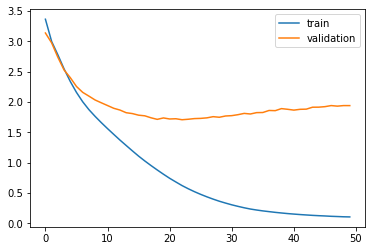

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

## Text Generator
We build a utility function to generate text sequences based on the output prediction sequences

In [18]:
from tqdm import tqdm
pd.set_option('display.max_colwidth', 500)

eng_idx2word = {v:k for k, v in eng_tokenizer.word_index.items()}

def generate_prediction_texts(pred_seqs, idx2word_map):
  pred_texts = []

  for pred in tqdm(preds):
    temp = []
    for idx in range(len(pred)):
      w = eng_idx2word.get(pred[idx], None)
      if idx > 0:
        if (w == eng_idx2word.get(pred[idx-1], None)) or (w == None):
            temp.append('')
        else:
            temp.append(w)
          
      else:
        if(w == None):
            temp.append('')
        else:
            temp.append(w)            
        
    pred_texts.append(' '.join(temp))
  return pred_texts

## Translation using seed from Training Data

In [19]:
train_spa_enc[:1000,:].shape

(1000, 12)

### **Question 5**: **Evaluate** model predictions using training samples only (3 points)


In [22]:
# Add your code here
pred_probs = model.predict(train_spa_enc[:1000,:].reshape((train_spa_enc[:1000,:].shape[0], 
                                                           train_spa_enc[:1000,:].shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': train_spa[:1000], 'target' : train_eng[:1000], 'predicted' : pred_texts})
pred_df.head(50).T

32/32 [==============================] - 0s 11ms/step


100%|██████████| 1000/1000 [00:00<00:00, 59212.31it/s]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,estoy intentando recordar,tom tiene grandes problemas,caminaban de dos en fondo,no te debo nada,estamos ilesos,por favor vuelve a intentarlo,es mi mejor amigo,tom tiene que levantarse temprano,hable más alto por favor,me pone triste escucharlo,no tientes a la suerte,tom se puso serio,tom evitaba a maría,yo era un niño travieso,firme abajo,llama a tu hermano,no me agrada el tráfico,¿qué viste después,toma tu medicación,no siento nada,no estoy muerta,tenemos una ventaja,estoy en el septimo cielo,la vida es injusta,he bloqueado la puerta,tom se lo contó,¡feliz año,¿la conoces,disculpe la tardanza,el perro se alejó,estamos rodeados,nos han vencido,no es tan importante,vete,ellos eran muy estrictos,tom ha madurado,¿tom está celoso,tom lo va a intentar,reúnete conmigo esta noche,¡no esperen,estás manejando demasiado rápido,el pasatiempo de tom es el golf,¿tienes gatos,estaré preparada,ella se sonroja,conoces a todos,yo saltaba,no me gusta la sopa espesa,esperad un segundo,su hija es enfermera
target,im trying to remember,tom has big problems,they walked two abreast,i owe you nothing,no ones injured,please try again,hes my best friend,tom has to get up early,speak louder please,i am sad to hear it,dont tempt fate,tom became serious,tom avoided mary,i was a naughty boy,sign it at the bottom,call your brother,i dont like the traffic,what did you see next,take your medication,i feel nothing,im not dead,we have one advantage,im in seventh heaven,lifes not fair,i locked the door,tom told him,happy new year,do you know her,im sorry im late,the dog went away,were surrounded,weve been defeated,it isnt that important,go,they were very strict,tom has mellowed out,is tom jealous,tom will try,meet me tonight,dont wait,youre driving too fast,toms hobby is golf,do you have cats,ill be ready,shes turning red,you know everyone,i jumped up and down,i dont like thick soup,wait one second,his daughter is a nurse
predicted,im trying to remember,tom has big problems,they walked two abreast,i owe you nothing,no ones injured,please try again,hes my best friend,tom has to get up early,louder please,i am sad to hear it,dont tempt fate,tom became serious,tom avoided mary,i was a naughty boy,sign it at the,call your brother,i dont like the traffic,what did you see next,take your medication,i feel nothing,im not dead,we have one advantage,im in seventh heaven,life not unfair,i locked the door,tom told him,happy new year,do you know her,im sorry for being,the dog went away,were in,weve been defeated,its isnt that important,go,they were very strict,tom has mellowed out,is tom jealous,tom will try,meet me tonight,dont wait,youre driving too fast,toms hobby is golf,do you have cats,ill be ready,shes turning red,you know everyone,i jumped up and down,i dont like thick soup,wait one second,his daughter is a nurse


## Translation on Test Data

### **Question 6**: **Evaluate** model performance on test data (3 points)


In [21]:
# Add your code here
pred_probs = model.predict(test_spa_enc[:1000,:].reshape((test_spa_enc[:1000,:].shape[0],
                                                          test_spa_enc[:1000,:].shape[1])), verbose=1)
preds = [np.argmax(i, axis=1) for i in pred_probs]
# convert predictions into text (English)
pred_texts = generate_prediction_texts(pred_seqs=preds, idx2word_map=eng_idx2word)
pred_df = pd.DataFrame({'source': test_spa[:1000], 'target' : test_eng[:1000], 'predicted' : pred_texts})

32/32 [==============================] - 0s 10ms/step


100%|██████████| 1000/1000 [00:00<00:00, 92981.53it/s]


In [23]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,estoy intentando recordar,tom tiene grandes problemas,caminaban de dos en fondo,no te debo nada,estamos ilesos,por favor vuelve a intentarlo,es mi mejor amigo,tom tiene que levantarse temprano,hable más alto por favor,me pone triste escucharlo,no tientes a la suerte,tom se puso serio,tom evitaba a maría,yo era un niño travieso,firme abajo,llama a tu hermano,no me agrada el tráfico,¿qué viste después,toma tu medicación,no siento nada,no estoy muerta,tenemos una ventaja,estoy en el septimo cielo,la vida es injusta,he bloqueado la puerta,tom se lo contó,¡feliz año,¿la conoces,disculpe la tardanza,el perro se alejó,estamos rodeados,nos han vencido,no es tan importante,vete,ellos eran muy estrictos,tom ha madurado,¿tom está celoso,tom lo va a intentar,reúnete conmigo esta noche,¡no esperen,estás manejando demasiado rápido,el pasatiempo de tom es el golf,¿tienes gatos,estaré preparada,ella se sonroja,conoces a todos,yo saltaba,no me gusta la sopa espesa,esperad un segundo,su hija es enfermera
target,im trying to remember,tom has big problems,they walked two abreast,i owe you nothing,no ones injured,please try again,hes my best friend,tom has to get up early,speak louder please,i am sad to hear it,dont tempt fate,tom became serious,tom avoided mary,i was a naughty boy,sign it at the bottom,call your brother,i dont like the traffic,what did you see next,take your medication,i feel nothing,im not dead,we have one advantage,im in seventh heaven,lifes not fair,i locked the door,tom told him,happy new year,do you know her,im sorry im late,the dog went away,were surrounded,weve been defeated,it isnt that important,go,they were very strict,tom has mellowed out,is tom jealous,tom will try,meet me tonight,dont wait,youre driving too fast,toms hobby is golf,do you have cats,ill be ready,shes turning red,you know everyone,i jumped up and down,i dont like thick soup,wait one second,his daughter is a nurse
predicted,im trying to remember,tom has big problems,they walked two abreast,i owe you nothing,no ones injured,please try again,hes my best friend,tom has to get up early,louder please,i am sad to hear it,dont tempt fate,tom became serious,tom avoided mary,i was a naughty boy,sign it at the,call your brother,i dont like the traffic,what did you see next,take your medication,i feel nothing,im not dead,we have one advantage,im in seventh heaven,life not unfair,i locked the door,tom told him,happy new year,do you know her,im sorry for being,the dog went away,were in,weve been defeated,its isnt that important,go,they were very strict,tom has mellowed out,is tom jealous,tom will try,meet me tonight,dont wait,youre driving too fast,toms hobby is golf,do you have cats,ill be ready,shes turning red,you know everyone,i jumped up and down,i dont like thick soup,wait one second,his daughter is a nurse
